In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import re

In [2]:
pattern = re.compile(r'(\d+):(\d+)\.(\d+)')
def to_time(s):
    m = pattern.search(s)
    if int(m.group(3)) > 10:
        return int(m.group(1))*60 + int(m.group(2)) + int(m.group(3))*0.001
    else:
        return int(m.group(1))*60 + int(m.group(2)) + int(m.group(3))*0.1

In [3]:
def DealWithTime(data):
#     data['time'] = data['timestamp'].apply(to_time)
#     return data.drop('timestamp',axis=1)
    data['time'] = pd.to_datetime(data['timestamp'])
    return data

In [4]:
def GetData(filename):
    data = pd.read_csv(filename)
    data = data[['loggingTime(txt)','motionUserAccelerationX(G)', 'motionUserAccelerationY(G)', 'motionUserAccelerationZ(G)',\
                 'gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',\
                 'motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']]
    colums_name = ['timestamp','accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'yaw','roll', 'pitch']
    data.columns = colums_name
    return data

In [5]:
def Overview(data):
    plt.figure(figsize=(15,20))
    p1 = plt.subplot(3,1,1)
    p2 = plt.subplot(3,1,2)
    p3 = plt.subplot(3,1,3)
    p1.plot(left['accX'])
    p2.plot(left['accY'])
    p3.plot(left['accZ'])
    plt.show()

    plt.figure(figsize=(15,20))
    p4 = plt.subplot(3,1,1)
    p5 = plt.subplot(3,1,2)
    p6 = plt.subplot(3,1,3)
    p4.plot(left['gyroX'])
    p5.plot(left['gyroY'])
    p6.plot(left['gyroZ'])
    plt.show()

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass(highcut, fs, order=3):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, highcut, fs, order=3):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def getStepFrequency(data):
    ffted = np.fft.fft(data)
    freqs = np.fft.fftfreq(len(ffted))
    idx = np.argmax(np.abs(ffted))
    freq = freqs[idx]
    return abs(freq*fs)

fs = 30

In [7]:
# left = GetData("../dataset/zmq_left_2017-11-27_14-31-39_-0800.csv")
# right =  GetData("../dataset/zmq_right_2017-11-27_14-31-48_-0800.csv")
left = GetData("../dataset/lzy_left_2017-11-27_14-36-05_-0800.csv")
right =  GetData("../dataset/lzy_right_2017-11-27_14-36-02_-0800.csv")

In [8]:
left = DealWithTime(left)
right = DealWithTime(right)

In [9]:
left = left[857:1300]
# left = left[450:1000] zmq
left = left.reset_index(drop=True)
# Overview(left)

In [10]:
highcut = 6
left['accX'] = butter_lowpass_filter(left['accX'],highcut, fs)
left['accY'] = butter_lowpass_filter(left['accY'],highcut, fs)
left['accZ'] = butter_lowpass_filter(left['accZ'],highcut, fs)

In [11]:
lowcut = 0.08
highcut = 7
left['gyroX'] = butter_bandpass_filter(left['gyroX'],lowcut, highcut, fs)
left['gyroY'] = butter_bandpass_filter(left['gyroY'],lowcut, highcut, fs)
left['gyroZ'] = butter_bandpass_filter(left['gyroZ'],lowcut, highcut, fs)

In [12]:
print(getStepFrequency(left['accY']))
print(getStepFrequency(left['accX']))
print(getStepFrequency(left['accZ']))
print(getStepFrequency(left['gyroY']))
print(getStepFrequency(left['gyroX']))
print(getStepFrequency(left['gyroZ']))

0.0
0.948081264108
0.948081264108
0.948081264108
0.948081264108
0.948081264108


In [13]:
step_frequency = getStepFrequency(left['gyroZ'])

In [14]:
step_cycle = int(round(fs/step_frequency))

In [15]:
# def seperateEachStep(data, step_cycle):
#     steps = pd.DataFrame()
#     for i in range(0, data.shape[0], step_cycle):
#         idx = np.argmin(data['gyroZ'].iloc[i:i+step_cycle])
#         steps = steps.append(data.iloc[idx])
#     return steps
def seperateEachStep(data, step_cycle):
    steps = pd.DataFrame()
    idx_list = []
    for i in range(0, data.shape[0], step_cycle):
        idx = np.argmin(data['gyroZ'].iloc[i:i+step_cycle])
        idx_list.append(idx)
#         steps = steps.append(data.iloc[idx])
    print(idx_list)
    for i in range(0, len(idx_list)-1):
        prev = idx_list[i]
        nxt = idx_list[i+1]
        interval = nxt - prev
        floor1 = int(prev + interval /3)
        floor2 = int(nxt - interval /3)
        idx = np.argmin(np.abs(data['gyroZ'].iloc[floor1:floor2]))
        steps = steps.append(data.iloc[idx])
    return steps

[6, 45, 79, 112, 146, 180, 214, 243, 273, 302, 331, 361, 391, 420]


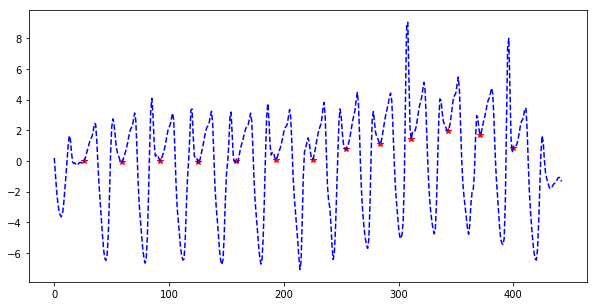

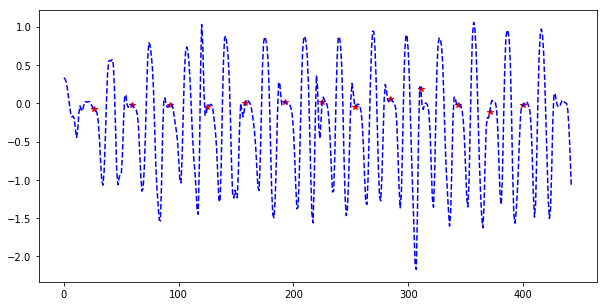

In [16]:
steps = seperateEachStep(left, step_cycle)
plt.figure(figsize=(10,5))
plt.plot(steps['gyroZ'],'r*',left['gyroZ'], 'b--')
plt.show()
plt.figure(figsize=(10,5))
plt.plot(steps['accY'],'r*',left['accY'], 'b--')
plt.show()

In [17]:
steps['initVy'] = 0
steps['initVx'] = 0.15* steps['gyroZ']
steps['endVy'] = 0
steps['endVx'] = steps['initVx'].shift(-1)

In [18]:
steps['begin_idx'] = steps.index
steps['end_idx'] = steps['begin_idx'].shift(-1)
steps = steps.dropna()
steps['end_idx'] = steps['end_idx'].astype(int)

In [19]:
def calcSpeedY(data, begin, end):
    return data.loc[begin:end, 'accY'].sum()/fs
def calcSpeedZ(data, begin, end):
    return data.loc[begin:end, 'accZ'].sum()/fs
def calcSpeedX(data, begin, end):
    return data.loc[begin:end, 'accX'].sum()/fs

In [20]:
steps['calcVy'] = steps.apply((lambda row: calcSpeedY(left, row['begin_idx'], row['end_idx'])), axis=1)
steps['calcVz'] = steps.apply((lambda row: calcSpeedZ(left, row['begin_idx'], row['end_idx'])), axis=1)
steps['calcVx'] = steps.apply((lambda row: calcSpeedX(left, row['begin_idx'], row['end_idx'])), axis=1)

In [21]:
steps['deltaVy'] = steps['endVy'] - steps['calcVy']
steps['deltaVx'] = steps['endVx'] - steps['calcVx'] 

In [22]:
steps['deltaT'] = (steps['end_idx'] - steps['begin_idx'])/fs

In [23]:
steps = steps.reset_index(drop=True)

In [24]:
begin = steps['begin_idx'].iloc[0]
end = steps['end_idx'].iloc[-1]
left_data = left[begin: end]
left_data['Vy'] = np.nan
left_data['Vx'] = np.nan
print(left_data)

                         timestamp      accX      accY      accZ     gyroX  \
26   2017-11-27 14:36:33.958 -0800  0.106273 -0.079466  0.055909 -0.306903   
27   2017-11-27 14:36:33.988 -0800  0.188415 -0.095168  0.123039 -0.373939   
28   2017-11-27 14:36:34.018 -0800  0.221995 -0.103600  0.151554 -0.510570   
29   2017-11-27 14:36:34.048 -0800  0.196056 -0.137715  0.105573 -0.690658   
30   2017-11-27 14:36:34.097 -0800  0.167812 -0.253422  0.062513 -0.844711   
31   2017-11-27 14:36:34.109 -0800  0.263820 -0.483171  0.176622 -0.932366   
32   2017-11-27 14:36:34.139 -0800  0.576575 -0.777906  0.472721 -1.055926   
33   2017-11-27 14:36:34.174 -0800  0.977858 -1.012840  0.723511 -1.398267   
34   2017-11-27 14:36:34.199 -0800  1.134223 -1.069366  0.682372 -1.869321   
35   2017-11-27 14:36:34.229 -0800  0.862408 -0.889491  0.420099 -1.998169   
36   2017-11-27 14:36:34.259 -0800  0.398168 -0.489781  0.237799 -1.534703   
37   2017-11-27 14:36:34.289 -0800  0.168884  0.001332  0.254399

/home/zhaoyangli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/zhaoyangli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [25]:
def CorrectedV(begin, end, deltaVy, deltaVx, deltaT, initVy, initVx, data):
    data.loc[begin,'Vy'] = initVy
    data.loc[begin,'Vx'] = initVx
    for i in range(int(begin+1), int(end)):
        data.loc[i,'Vy'] = data.loc[i-1,'Vy']+ (data.loc[i-1,'accY'] + deltaVy/deltaT)/fs
        data.loc[i,'Vx'] = data.loc[i-1,'Vx']+ (data.loc[i-1,'accX'] + deltaVx/deltaT)/fs

In [26]:
steps.apply((lambda row: CorrectedV(row['begin_idx'], row['end_idx'], row['deltaVy'], row['deltaVx'], row['deltaT'],\
                                   row['initVy'], row['initVx'], left_data)), axis=1)

/home/zhaoyangli/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
dtype: object

In [27]:
def getFC(data, begin, end):
    return data.loc[begin:end, 'Vy'].sum()/fs

In [28]:
steps['FC'] = steps.apply((lambda row: getFC(left_data, row['begin_idx'], row['end_idx'])), axis=1)
print(steps)

        accX      accY      accZ     gyroX     gyroY     gyroZ     pitch  \
0   0.106273 -0.079466  0.055909 -0.306903  1.312159 -0.021538  1.227821   
1   0.119341 -0.020563 -0.034417 -0.147089  1.233019 -0.068378  1.249908   
2   0.204811 -0.021604 -0.041387 -0.064474  0.655735  0.007841  1.259913   
3   0.096381 -0.042343  0.014854  0.114939  0.340028 -0.083422  1.250260   
4   0.213060  0.006750  0.018659  0.189284  0.308527 -0.039655  1.219279   
5  -0.002960  0.016034  0.136774 -0.085170  0.603744  0.056582  1.248039   
6   0.074759  0.016597  0.083249 -0.130603  0.783473  0.086749  1.236896   
7  -0.000726 -0.044404  0.055008 -0.238001  0.442317  0.752216  1.268690   
8  -0.266919  0.055429  0.129528 -0.578594  1.062349  1.096612  1.252329   
9  -1.084775  0.184237  0.421839 -0.988511  1.219746  1.421991  1.241280   
10  0.088592 -0.024376  0.063375 -1.037105  1.526068  1.978773  1.242561   
11  0.374542 -0.115540  0.250373 -0.911575  1.208012  1.704445  1.235657   

        rol

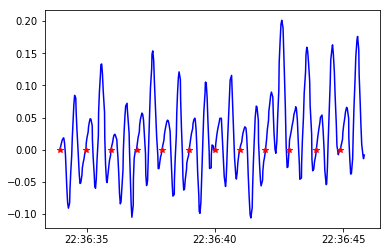

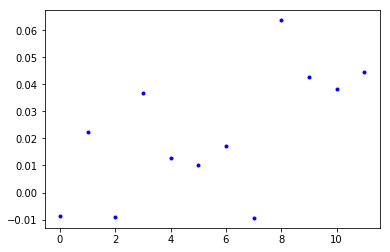

In [32]:
plt.plot(left_data['time'], left_data['Vy'], 'b-')
plt.plot(steps['time'], steps['endVy'], 'r*')
plt.show()
plt.plot(steps['FC'], 'b.')
plt.show()

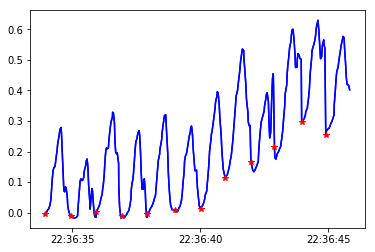

In [35]:
plt.plot(left_data['time'], left_data['Vx'], 'b-')
plt.plot(steps['time'], steps['initVx'], 'r*')
plt.show()